In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
import dask
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})
import gc
import shutil
import os

In [2]:
overwrite=True

In [3]:
n_cores = 5
mem_lim = str(int(np.floor(95/n_cores)))+'GB'

In [4]:
n_cores = 5
mem_lim = str(int(np.floor(95/n_cores)))+'GB'
dask_dir = '/p/scratch/chhb19/mueller29/dask_dir/wpbp/' #temporary folder
if os.path.exists(dask_dir):
    shutil.rmtree(dask_dir)
    
if 'client' in locals() or 'client' in globals():
    client.close()
client = Client(local_directory=dask_dir,n_workers=n_cores, threads_per_worker=1,memory_limit=mem_lim)
client.restart()
client.amm.start() #automatic memory management
client

/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46871 instead
  warnings.warn(
2023-03-22 14:53:58,699 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:53:58,759 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:53:58,772 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:53:58,774 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:53:58,787 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/46871/status,
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/46871/status,Workers: 5
Total threads: 5,Total memory: 88.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35995,Workers: 5
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/46871/status,Total threads: 5
Started: Just now,Total memory: 88.48 GiB
Comm: tcp://127.0.0.1:45461,Total threads: 1
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/39273/status,Memory: 17.70 GiB
Nanny: tcp://127.0.0.1:43677,


In [2]:
#paths 
data_path = '/p/scratch/chhb19/mueller29/AO_40_nopc/'
out_path = '/p/scratch/chhb19/mueller29/regional/'
mesh_path = '/p/project/chhb19/mueller29/meshes/AO_40/'

In [6]:
# chunk sizes
horizontal_split = 1000000
horizontal_split3D = 500000
vertical_split = 12
time_split = 1

In [7]:
#region = 'basin' #'basin','nansen','amundsen','eastern'
region = 'basin'

In [8]:
if region == 'marginal':
    mat = loadmat('/p/project/chhb19/mueller29/mat_files/model_ind_basin.mat')
    indices=(mat[('ind_basin')]==1).flatten()
    ds = xr.open_mfdataset(data_path+'a_ice.fesom.*.nc', chunks={'time': time_split}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)['a_ice'].astype('float32') 
    ds_clim = ds.groupby("time.month").mean("time")
    indices = indices & (ds_clim.isel(month=8)<.8)
    indices = indices.compute()
    indices = indices.drop_vars('month')
    indices = np.multiply(indices, 1)
    indices = xr.DataArray(
        data=indices,
        dims=['nod2'],
    )
elif region=='eastern':
    lon = xr.open_dataset((mesh_path+'fesom.mesh.diag.nc'))['lon'].astype('float32').values
    lat = xr.open_dataset((mesh_path+'fesom.mesh.diag.nc'))['lat'].astype('float32').values
    indices = np.zeros_like(lon)
    reg_eeb = (lon>95)&(lon<145)&(lat>76)&(lat<85);
    indices[reg_eeb]=1
    indices = xr.DataArray(
        data=indices,
        dims=['nod2'],
    )
else:
    mat = loadmat('/p/project/chhb19/mueller29/mat_files/model_ind_'+region+'.mat')
    indices=(mat[('ind_'+region)]==1).flatten()
    indices = np.multiply(indices, 1)
    indices = xr.DataArray(
        data=indices,
        dims=['nod2'],
    )

In [10]:
nod_area = xr.open_dataset((mesh_path+'fesom.mesh.diag.nc'))['nod_area'].astype('float32')  
#nod_area = diag.nod_area*indices.compute()
nod_area = nod_area*indices
nod_area_surf = nod_area.isel(nz=0).drop_vars('nz')

nod_area.coords['nz']=xr.open_dataset(data_path+'N2.fesom.2015.nc').coords['nz'].values 

nz1 = xr.open_dataset(data_path+'salt.fesom.2015.nc').coords['nz1'].values
tmp1=nod_area[0:-1,:]
tmp2=nod_area[1::,:]
tmp1.coords['nz']=nz1
tmp2.coords['nz']=nz1
nod_area_mid = (tmp1+tmp2)/2
nod_area_mid = nod_area_mid.rename({'nz': 'nz1'})

# and chunk the masks
nod_area=nod_area.chunk(chunks={'nod2':horizontal_split})
#nod_area_surf=nod_area_surf.chunk(chunks={'nod2':horizontal_split})
#nod_area_mid=nod_area_mid.chunk(chunks={'nod2':horizontal_split,'nz1':vertical_split})
nod_area_mid=nod_area_mid.chunk(chunks={'nod2':horizontal_split3D})


In [ ]:
# atmosphere - ocean stress 2D daily 
client.run(gc.collect)
client.restart()
var='atmoce_x'
ds1 = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': time_split}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
ds1 = ds1*indices
var='atmoce_y'
ds2 = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': time_split}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
ds2 = ds2*indices
ds = (ds1**2+ds2**2)**0.5
ds = ds.weighted(nod_area_surf).mean(dim='nod2')

var='atmoce'
#make xarray dataset
ex_stri='ds_out = xr.Dataset(data_vars=dict('+var+'=ds,),attrs=dict(description="average '+var+' in '+region+'"),)'
exec(ex_stri)
#write dataset to disk
outfile = (out_path+var+'.fesom.timeseries.'+region+'.nc')
if (os.path.exists(outfile))&(overwrite==True):
    os.remove(outfile)
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' overwritten')
elif (os.path.exists(outfile))&(overwrite==False):
    print(var+' skipped')
else:   
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' done')

In [ ]:
# ice - ocean stress 2D daily 
client.run(gc.collect)
client.restart()
var='iceoce_x'
ds1 = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': time_split}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
ds1 = ds1*indices
var='iceoce_y'
ds2 = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': time_split}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
ds2 = ds2*indices
ds = (ds1**2+ds2**2)**0.5
ds = ds.weighted(nod_area_surf).mean(dim='nod2')

var='iceoce'
#make xarray dataset
ex_stri='ds_out = xr.Dataset(data_vars=dict('+var+'=ds,),attrs=dict(description="average '+var+' in '+region+'"),)'
exec(ex_stri)
#write dataset to disk
outfile = (out_path+var+'.fesom.timeseries.'+region+'.nc')
if (os.path.exists(outfile))&(overwrite==True):
    os.remove(outfile)
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' overwritten')
elif (os.path.exists(outfile))&(overwrite==False):
    print(var+' skipped')
else:   
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' done')

In [17]:
# thermodyn. growth rate + sea ice conc. + surface heat flux 2D daily 
vars_daily = ('thdgr','a_ice','fh')
for var in vars_daily:
    ds = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': 12}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
    #ds = ds*indices
    #ds = weighted_mean(ds,nod_area_surf) 
    ds = ds.weighted(nod_area_surf).mean(dim='nod2')
    #make xarray dataset
    ex_stri='ds_out = xr.Dataset(data_vars=dict('+var+'=ds,),attrs=dict(description="average '+var+' in '+region+'"),)'
    exec(ex_stri)
    #write dataset to disk
    outfile = (out_path+var+'.fesom.timeseries.'+region+'.nc')
    if (os.path.exists(outfile))&(overwrite==True):
        os.remove(outfile)
        ds_out.to_netcdf(outfile, compute=True)
        print(var+' overwritten')
    elif (os.path.exists(outfile))&(overwrite==False):
        print(var+' skipped')
    else:   
        ds_out.to_netcdf(outfile, compute=True)
        print(var+' done')

thdgr done
a_ice done
fh skipped


In [19]:
# mixed layer depth 2D monthly 
var='MLD2'
client.run(gc.collect)
client.restart()
ds = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': time_split,'nod2':horizontal_split}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
ds = ds.weighted(nod_area_surf).mean(dim='nod2')
#make xarray dataset
ex_stri='ds_out = xr.Dataset(data_vars=dict('+var+'=ds,),attrs=dict(description="average '+var+' in '+region+'"),)'
exec(ex_stri)
#write dataset to disk
outfile = (out_path+var+'.fesom.timeseries.'+region+'.nc')

if (os.path.exists(outfile))&(overwrite==True):
    os.remove(outfile)
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' overwritten')
elif (os.path.exists(outfile))&(overwrite==False):
    print(var+' skipped')
else:   
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' done')

2023-01-27 15:13:58,945 - distributed.nanny - WARNING - Restarting worker
2023-01-27 15:13:59,070 - distributed.nanny - WARNING - Restarting worker
2023-01-27 15:13:59,071 - distributed.nanny - WARNING - Restarting worker
2023-01-27 15:13:59,072 - distributed.nanny - WARNING - Restarting worker
2023-01-27 15:13:59,124 - distributed.nanny - WARNING - Restarting worker


MLD2 done


In [21]:
# stratification 3D monthly 
var='N2'
client.run(gc.collect)
client.restart()
ds = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': time_split,'nod2':horizontal_split3D}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
#ds = ds*indices
#ds = weighted_mean(ds,nod_area)
ds = ds.weighted(nod_area).mean(dim='nod2')
#make xarray dataset
ex_stri='ds_out = xr.Dataset(data_vars=dict('+var+'=ds,),attrs=dict(description="average '+var+' in '+region+'"),)'
exec(ex_stri)
#write dataset to disk
outfile = (out_path+var+'.fesom.timeseries.'+region+'.nc')
if (os.path.exists(outfile))&(overwrite==True):
    os.remove(outfile)
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' overwritten')
elif (os.path.exists(outfile))&(overwrite==False):
    print(var+' skipped')
else:   
    ds_out.to_netcdf(outfile, compute=True)
    print(var+' done')

2023-01-27 15:16:33,778 - distributed.nanny - WARNING - Restarting worker
2023-01-27 15:16:33,796 - distributed.nanny - WARNING - Restarting worker
2023-01-27 15:16:33,808 - distributed.nanny - WARNING - Restarting worker
2023-01-27 15:16:33,891 - distributed.nanny - WARNING - Restarting worker


N2 done


In [11]:
# temperature/salinity 3D monthly 
vars = ('temp','salt')
for var in vars:
    client.run(gc.collect)
    client.restart()
    ds = xr.open_mfdataset(data_path+var+'.fesom.*.nc', chunks={'time': time_split,'nod2':horizontal_split3D}, concat_dim='time', combine='nested',data_vars='minimal', coords='minimal', compat='override', parallel=True)[var].astype('float32') 
    #ds = ds*indices
    #ds = weighted_mean(ds,nod_area_mid)
    ds = ds.weighted(nod_area_mid).mean(dim='nod2')

    #make xarray dataset
    ex_stri='ds_out = xr.Dataset(data_vars=dict('+var+'=ds,),attrs=dict(description="average '+var+' in '+region+'"),)'
    exec(ex_stri)
    #write dataset to disk
    outfile = (out_path+var+'.fesom.timeseries.'+region+'.nc')
    if (os.path.exists(outfile))&(overwrite==True):
        os.remove(outfile)
        ds_out.to_netcdf(outfile, compute=True)
        print(var+' overwritten')
    elif (os.path.exists(outfile))&(overwrite==False):
        print(var+' skipped')
    else:   
        ds_out.to_netcdf(outfile, compute=True)
        print(var+' done')

2023-03-22 14:54:52,695 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:54:52,699 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:54:52,715 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:54:52,717 - distributed.nanny - WARNING - Restarting worker
2023-03-22 14:54:52,722 - distributed.nanny - WARNING - Restarting worker


temp overwritten


2023-03-22 15:00:34,024 - distributed.nanny - WARNING - Restarting worker
2023-03-22 15:00:34,049 - distributed.nanny - WARNING - Restarting worker
2023-03-22 15:00:34,059 - distributed.nanny - WARNING - Restarting worker
2023-03-22 15:00:34,067 - distributed.nanny - WARNING - Restarting worker
2023-03-22 15:00:34,092 - distributed.nanny - WARNING - Restarting worker


salt overwritten


In [24]:
client.close()

In [1]:
import xarray as xr


In [9]:
ds = xr.open_dataset(out_path+'salt.fesom.timeseries.basin.nc')['salt']

In [10]:
ds

<xarray.DataArray 'salt' (time: 72, nz1: 69)>
array([[32.493921, 32.495738, 32.505169, ...,       nan,       nan,       nan],
       [32.627208, 32.628432, 32.633351, ...,       nan,       nan,       nan],
       [32.694907, 32.697215, 32.703774, ...,       nan,       nan,       nan],
       ...,
       [31.034669, 31.041339, 31.27531 , ...,       nan,       nan,       nan],
       [31.682615, 31.684225, 31.70729 , ...,       nan,       nan,       nan],
       [32.046861, 32.047945, 32.068404, ...,       nan,       nan,       nan]])
Coordinates:
  * nz1      (nz1) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.125e+03
  * time     (time) datetime64[ns] 2015-01-31T23:58:00 ... 2020-12-31T23:58:00

In [12]:
from matplotlib import pyplot as plt


(500.0, 0.0)

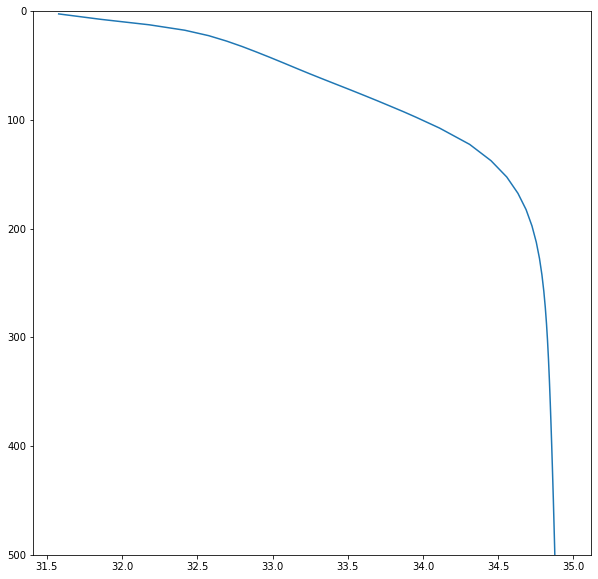

In [18]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10,10),
)
ax.plot(ds.mean(dim='time'),ds.nz1)
ax.invert_yaxis()
ax.set_ylim(bottom=500,top=0)

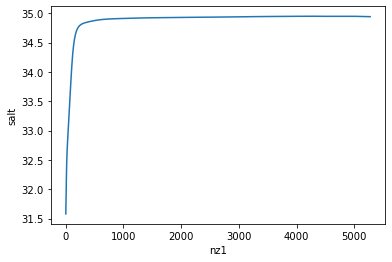

In [11]:
.plot()